In [45]:
import numpy as np
import tqdm as tqdm
import sklearn.datasets as skd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.stats import kde

import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp
import sonnet as snt
tf.enable_v2_behavior()

tfb = tfp.bijectors
tfd = tfp.distributions

def make_grid(xmin,xmax, ymin, ymax, gridlines, pts):
    xpts = np.linspace(xmin, xmax, pts)
    ypts = np.linspace(ymin, ymax ,pts)
    xgrid = np.linspace(xmin, xmax, gridlines)
    ygrid = np.linspace(ymin, ymax, gridlines)
    xlines = np.stack([a.ravel() for a in np.meshgrid(xpts, ygrid)])
    ylines = np.stack([a.ravel() for a in np.meshgrid(xgrid, ypts)])
    return np.concatenate([xlines, ylines], 1).T

grid = make_grid(-3,3,-3,3,4,100)
    

In [46]:
def plot_density(data, axis):
    x, y = np.squeeze(np.split(data , 2, axis=1))
    levels = np.linspace(0.0, 0.75, 10)
    kwargs = {'levels': levels}
    return sns.kdeplot(x=x, y=y, cmap="viridis", shade=True,
                      thresh=True, ax=axis, **kwargs)

def plot_points(data, axis, s=10, color='b', label=''):
    x, y = np.squeeze(np.split(data, 2, axis=1))
    axis.scatter(x, y, c=color, s=s, label=label)

def plot_panel(
    grid, samples, transformed_grid, transformed_samples,
    dataset, axarray, limit=True):
    if len(axarray) != 4:
        raise ValueError("Expected 4 axes for the pannel")
    ax1, ax2, ax3, ax4 = axarray
    plot_points(grid, axis=ax1, s=20, color='black', label='grid')
    plot_points(samples, axis=ax1, s=30, color='blue', label='samples')
    plot_points(transformed_grid, axis=ax2, s=20, color='black', label='ode(grid)')
    plot_points(transformed_samples, axis=ax2, s=30, color='blue', label='ode(samples)')
    ax3 = plot_density(transformed_samples, ax3)
    ax4 = plot_density(dataset, ax4)
    if limit:
        set_limits([ax1], -3.0, 3.0, -3.0, 3.0)
        set_limits([ax2], -2.0, 3.0, -2.0, 3.0)
        set_limits([ax3, ax4], -1.5, 2.5, -0.75, 1.25)

def set_limits(axes, min_x, max_x, min_y, max_y):
    if isinstance(axes, list):
        for axis in axes:
            set_limits(axis, min_x, max_x, min_y, max_y)
    else:
        axes.set_xlim(min_x, max_x)
        axes.set_ylim(min_y, max_y)

In [47]:
DATASET_SIZE = 30000
BATCH_SIZE = 512
SAMPLE_SIZE = DATASET_SIZE

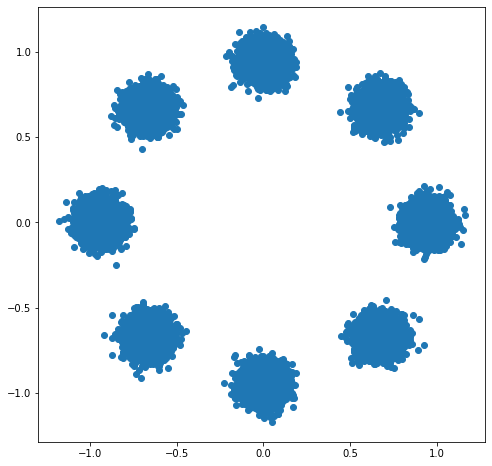

In [48]:
scale = 8
centers = [(1, 0), (-1, 0), (0, 1), (0, -1), (1. / np.sqrt(2), 1. / np.sqrt(2)),
          (1. / np.sqrt(2), -1. / np.sqrt(2)), (-1. / np.sqrt(2), 1. / np.sqrt(2)),
          (-1. / np.sqrt(2), -1. / np.sqrt(2))]
centers = [(scale * x, scale * y) for x, y in centers]

dataset = []
rng = np.random.RandomState()
for i in range(DATASET_SIZE):
    point = rng.randn(2) * 0.5
    idx = rng.randint(8)
    center = centers[idx]
    point[0] += center[0]
    point[1] += center[1]
    dataset.append(point)
dataset = np.array(dataset, dtype="float32")
dataset /= (1.414*6)
eight_gaussian = dataset

eight_gaussian_ds = tf.data.Dataset.from_tensor_slices(eight_gaussian.astype(np.float32))
eight_gaussian_ds = eight_gaussian_ds.prefetch(tf.data.experimental.AUTOTUNE)
eight_gaussian_ds = eight_gaussian_ds.cache()
eight_gaussian_ds = eight_gaussian_ds.shuffle(DATASET_SIZE)
eight_gaussian_ds = eight_gaussian_ds.batch(BATCH_SIZE)

plt.figure(figsize=[8, 8])
plt.scatter(eight_gaussian[:, 0], eight_gaussian[:, 1])
plt.show()

(30000, 2)


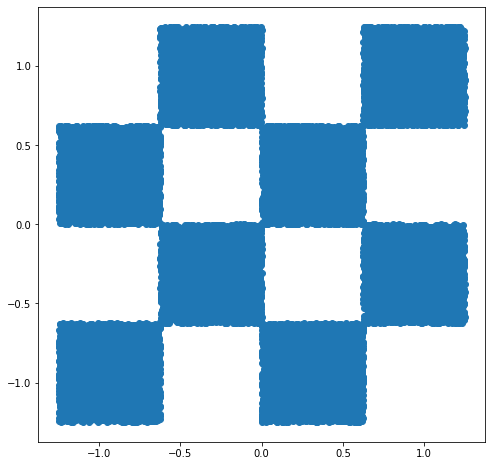

In [64]:
x1 = np.random.rand(DATASET_SIZE) * 4 - 2
x2_ = np.random.rand(DATASET_SIZE) - np.random.randint(0, 2, DATASET_SIZE) * 2
x2 = x2_ + (np.floor(x1) % 2)

checkerboard = np.concatenate([x1[:, None], x2[:, None]], 1) * .625
print(checkerboard.shape)

checkerboard_ds = tf.data.Dataset.from_tensor_slices(checkerboard.astype(np.float32))
checkerboard_ds = checkerboard_ds.prefetch(tf.data.experimental.AUTOTUNE)
checkerboard_ds = checkerboard_ds.cache()
checkerboard_ds = checkerboard_ds.shuffle(DATASET_SIZE)
checkerboard_ds = checkerboard_ds.batch(BATCH_SIZE)

plt.figure(figsize=[8, 8])
plt.scatter(checkerboard[:, 0], checkerboard[:, 1])
plt.show()

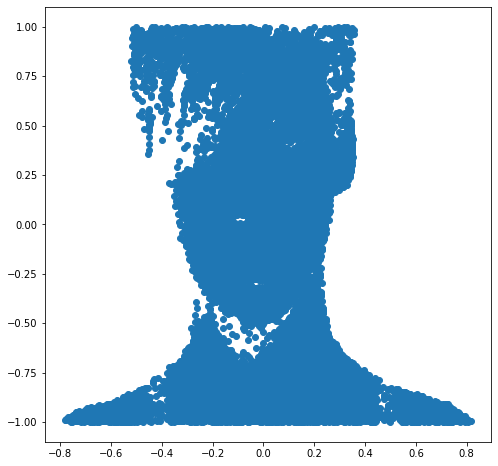

In [66]:
from PIL import Image
img = np.array(Image.open('rihanna.jpg').convert('L'))[::-1]
img_prob = (img/img.sum()).ravel()
idx = np.unravel_index(np.random.choice(img.size, DATASET_SIZE, p=img_prob), img.shape)
rand_img = np.stack(idx[::-1], -1)
rand_img = rand_img + np.random.uniform(0, 1, rand_img.shape)
rand_img = (rand_img/img.shape[::-1])*2 - 1

rand_img_ds = tf.data.Dataset.from_tensor_slices(rand_img.astype(np.float32))
rand_img_ds = rand_img_ds.prefetch(tf.data.experimental.AUTOTUNE)
rand_img_ds = rand_img_ds.cache()
rand_img_ds = rand_img_ds.shuffle(DATASET_SIZE)
rand_img_ds = rand_img_ds.batch(BATCH_SIZE)

plt.figure(figsize=[8, 8])
plt.scatter(rand_img[:, 0], rand_img[:, 1])
plt.show()

In [51]:
base_loc = np.array([0.0, 0.0]).astype(np.float32)
base_sigma = np.array([0.8, 0.8]).astype(np.float32)
base_distribution = tfd.MultivariateNormalDiag(base_loc, base_sigma)

In [52]:
class MLP_ODE(snt.Module):
    """Multi-layer NN ode_fn."""
    def __init__(self, num_hidden, num_layers, num_output, name='mlp_ode'):
        super(MLP_ODE, self).__init__(name=name)
        self._num_hidden = num_hidden
        self._num_output = num_output
        self._num_layers = num_layers
        self._modules = []
        for _ in range(self._num_layers - 1):
            self._modules.append(snt.Linear(self._num_hidden))
            self._modules.append(tf.math.tanh)
        self._modules.append(snt.Linear(self._num_output))
        self._model = snt.Sequential(self._modules)

    def __call__(self, t, inputs):
        inputs = tf.concat([tf.broadcast_to(t, inputs.shape), inputs], -1)
        return self._model(inputs)

In [53]:
#@title Model and training parameters
LR = 1e-2  #@param
NUM_EPOCHS = 80  #@param
STACKED_FFJORDS = 4  #@param
NUM_HIDDEN = 8  #@param
NUM_LAYERS = 3  #@param
NUM_OUTPUT = 2

In [54]:
solver = tfp.math.ode.DormandPrince(atol=1e-5)
ode_solve_fn = solver.solve
trace_augmentation_fn = tfb.ffjord.trace_jacobian_exact

bijectors = []
for _ in range(STACKED_FFJORDS):
    mlp_model = MLP_ODE(NUM_HIDDEN, NUM_LAYERS, NUM_OUTPUT)
    next_ffjord = tfb.FFJORD(
        state_time_derivative_fn=mlp_model,ode_solve_fn=ode_solve_fn,
        trace_augmentation_fn=trace_augmentation_fn
    )
    bijectors.append(next_ffjord)

stacked_ffjord = tfb.Chain(bijectors[::-1])

In [55]:
transformed_distribution = tfd.TransformedDistribution(
    distribution=base_distribution, bijector=stacked_ffjord)

In [56]:
@tf.function
def train_step(optimizer, target_sample):
    with tf.GradientTape() as tape:
        loss = -tf.reduce_mean(transformed_distribution.log_prob(target_sample))
    variables = tape.watched_variables()
    gradients = tape.gradient(loss, variables)
    optimizer.apply(gradients, variables)
    return loss

In [57]:
@tf.function
def get_samples():
    base_distribution_samples = base_distribution.sample(SAMPLE_SIZE)
    transformed_samples = transformed_distribution.sample(SAMPLE_SIZE)
    return base_distribution_samples, transformed_samples


@tf.function
def get_transformed_grid():
    transformed_grid = stacked_ffjord.forward(grid)
    return transformed_grid

In [58]:
evaluation_samples = []
base_samples, transformed_samples = get_samples()
transformed_grid = get_transformed_grid()
evaluation_samples.append((base_samples, transformed_samples, transformed_grid))

In [16]:
learning_rate = tf.Variable(LR, trainable=False)
optimizer = snt.optimizers.Adam(learning_rate)

for epoch in tqdm.trange(NUM_EPOCHS // 2):
    base_samples, transformed_samples = get_samples()
    transformed_grid = get_transformed_grid()
    evaluation_samples.append(
        (base_samples, transformed_samples, transformed_grid))
    for batch in eight_gaussian_ds:
        _ = train_step(optimizer, batch)

  0%|          | 0/40 [00:00<?, ?it/s]

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


100%|██████████| 40/40 [19:19<00:00, 28.99s/it] 


In [19]:
panel_id = -1
panel_data_eight = evaluation_samples[panel_id]
print("save result in panel_data_eight")

save result in panel_data_eight


In [34]:
learning_rate = tf.Variable(LR, trainable=False)
optimizer = snt.optimizers.Adam(learning_rate)

for epoch in tqdm.trange(NUM_EPOCHS // 2):
    base_samples, transformed_samples = get_samples()
    transformed_grid = get_transformed_grid()
    evaluation_samples.append(
        (base_samples, transformed_samples, transformed_grid))
    for batch in checkerboard_ds:
        _ = train_step(optimizer, batch)

100%|██████████| 40/40 [17:29<00:00, 26.25s/it] 


In [36]:
panel_id = -1
panel_data_checkboard = evaluation_samples[panel_id]
print("save result in panel_data_checkboard")

save result in panel_data_checkboard


In [67]:
learning_rate = tf.Variable(LR, trainable=False)
optimizer = snt.optimizers.Adam(learning_rate)

for epoch in tqdm.trange(NUM_EPOCHS // 2):
    base_samples, transformed_samples = get_samples()
    transformed_grid = get_transformed_grid()
    evaluation_samples.append(
        (base_samples, transformed_samples, transformed_grid))
    for batch in rand_img_ds:
        _ = train_step(optimizer, batch)

100%|██████████| 40/40 [15:28<00:00, 23.21s/it] 


In [68]:
panel_id = -1
panel_data_rand_img = evaluation_samples[panel_id]
print("save result in panel_data_rand_img")

save result in panel_data_rand_img


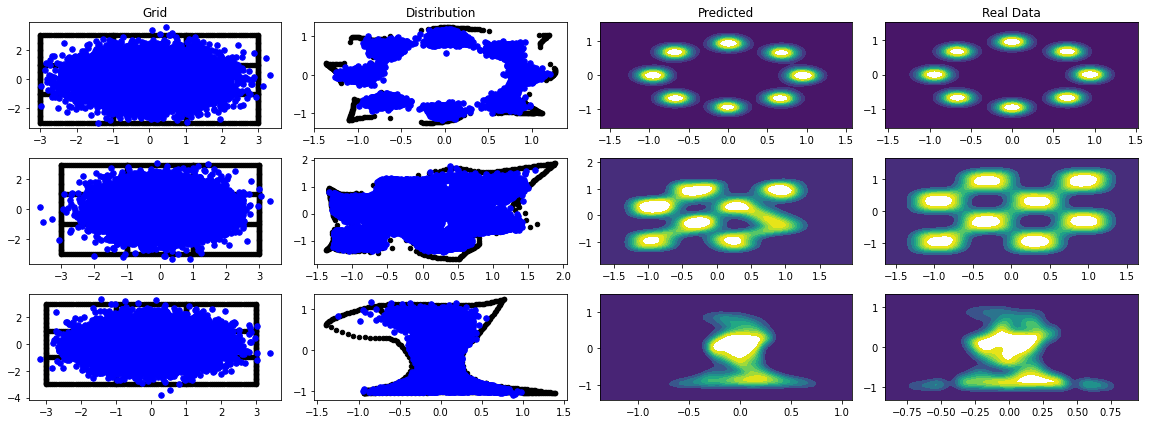

In [71]:
fig, axarray = plt.subplots(3, 4, figsize=(16, 6))
axarray[0][0].set_title("Grid")
axarray[0][1].set_title("Distribution")
axarray[0][2].set_title("Predicted")
axarray[0][3].set_title("Real Data")
plot_panel(grid, panel_data_eight[0], panel_data_eight[2], panel_data_eight[1], eight_gaussian, axarray[0], False)
plot_panel(grid, panel_data_checkboard[0], panel_data_checkboard[2], panel_data_checkboard[1], checkerboard, axarray[1], False)
plot_panel(grid, panel_data_rand_img[0], panel_data_rand_img[2], panel_data_rand_img[1], rand_img, axarray[2], False)
plt.tight_layout()